# Урок 4. Uplift-моделирование
  
Ссылки  
https://towardsdatascience.com/a-quick-uplift-modeling-introduction-6e14de32bfe0  
https://habr.com/ru/company/ru_mts/blog/485980/#reference1  
https://en.wikipedia.org/wiki/Uplift_modelling  
https://www.youtube.com/watch?v=yFQAIJBYXI0  
https://www.youtube.com/watch?v=jCUcYiBK03I  
https://www.uplift-modeling.com/en/latest/  
https://arxiv.org/pdf/1809.04559.pdf  
https://catboost.ai/docs/concepts/about.html  

# Домашнее задание
1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.models import ClassTransformation
from sklift.models import TwoModels

from catboost import CatBoostClassifier

In [2]:
DATA_PATH = './data/data.csv'

In [3]:
df = pd.read_csv(DATA_PATH)
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [4]:
# rename target column
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)

# replace treatment values
df['treatment'].replace({'Buy One Get One': 1, 'Discount': 1, 'No Offer': 0}, inplace=True)

# features df
X = df[list(df.columns[:-1])]

# getting dummies
X = pd.get_dummies(X, prefix=['zip_code', 'channel'])

# normalizing numerical features
X_norm = X.copy()
X_norm = X_norm.astype(np.float64)
col_list = ['recency', 'history']
for col in col_list:
    X_norm[col] = (X[col] - X[col].min()) / (X[col].max() - X[col].min())
X = X_norm.copy()

# target column
y = df[df.columns[-1]]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
X_train

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
43820,0.272727,0.060013,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
36500,0.909091,0.030344,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
38039,0.727273,0.000000,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1954,0.090909,0.046623,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
28361,0.727273,0.020046,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
62570,0.181818,0.074253,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
38158,0.272727,0.004071,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
860,0.636364,0.139490,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
15795,0.363636,0.012754,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [6]:
treat_train = X_train['treatment'].copy()
treat_test = X_test['treatment'].copy()
treat_test

33042    1.0
7209     1.0
24367    1.0
19599    1.0
31465    1.0
        ... 
29518    0.0
40886    0.0
19792    0.0
31101    1.0
54307    1.0
Name: treatment, Length: 12800, dtype: float64

uplift@10%: 0.1272
uplift@20%: 0.0896
uplift@30%: 0.0817


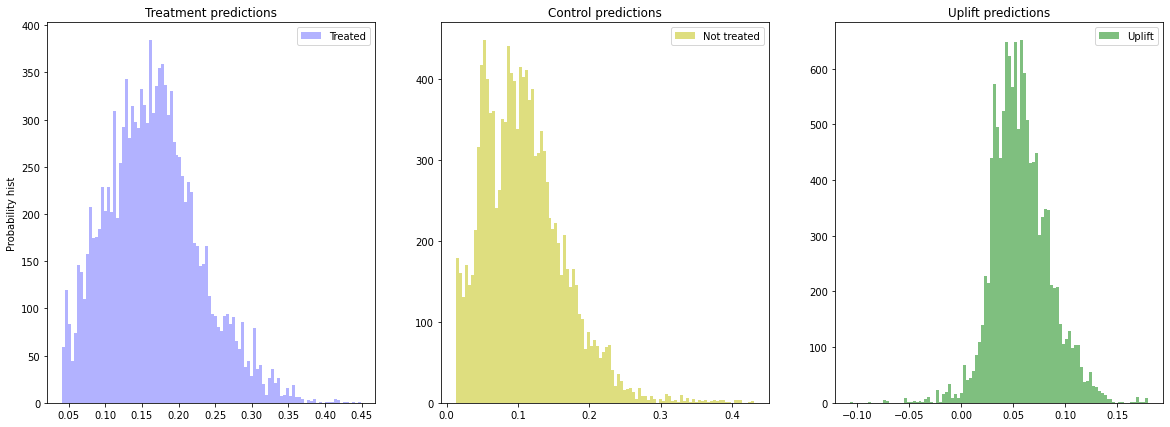

In [7]:
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': [],
    'uplift@30%': []
}

sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

sm_score10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
sm_score30 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)
print(f'uplift@10%: {sm_score10:.4f}\nuplift@20%: {sm_score20:.4f}\nuplift@30%: {sm_score30:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score10)
models_results['uplift@20%'].append(sm_score20)
models_results['uplift@30%'].append(sm_score30)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

uplift@10%: 0.0918
uplift@20%: 0.0983
uplift@30%: 0.0949


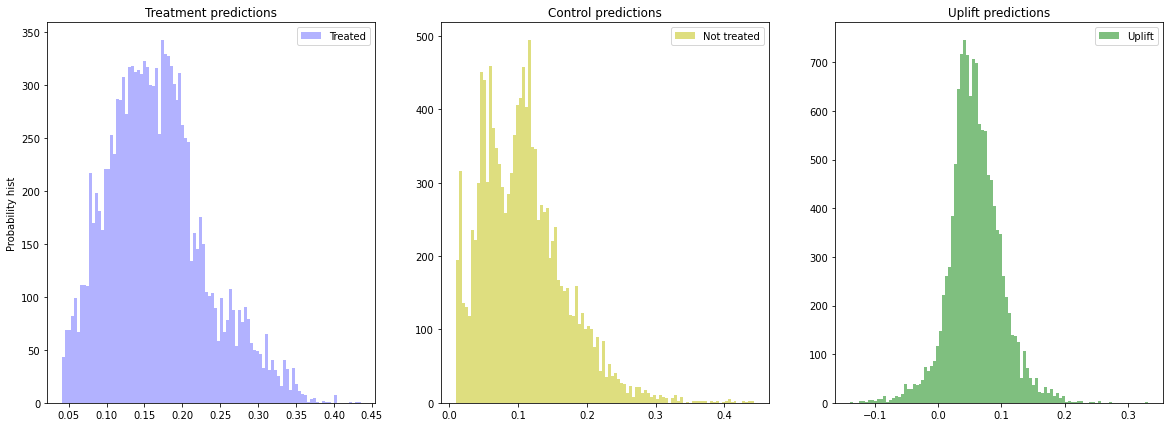

In [8]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train
)

uplift_tm = tm.predict(X_test)

tm_score10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)
tm_score30 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)
print(f'uplift@10%: {tm_score10:.4f}\nuplift@20%: {tm_score20:.4f}\nuplift@30%: {tm_score30:.4f}')

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score10)
models_results['uplift@20%'].append(tm_score20)
models_results['uplift@30%'].append(tm_score30)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [9]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)
ct_score30 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)
print(f'uplift@10%: {ct_score10:.4f}\nuplift@20%: {ct_score20:.4f}\nuplift@30%: {ct_score30:.4f}')

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score10)
models_results['uplift@20%'].append(ct_score20)
models_results['uplift@30%'].append(ct_score30)

uplift@10%: 0.2849
uplift@20%: 0.2181
uplift@30%: 0.1783


In [10]:
models_results = pd.DataFrame(models_results)
models_results.set_index('approach', inplace=True)
models_results

,uplift@10%,uplift@20%,uplift@30%
approach,,,
SoloModel,0.127199,0.089604,0.081721
TwoModels,0.091817,0.098316,0.094910
ClassTransformation,0.284903,0.218115,0.178269


In [12]:
X_train

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
43820,0.272727,0.060013,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
36500,0.909091,0.030344,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
38039,0.727273,0.000000,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1954,0.090909,0.046623,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
28361,0.727273,0.020046,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
62570,0.181818,0.074253,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
38158,0.272727,0.004071,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
860,0.636364,0.139490,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
15795,0.363636,0.012754,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [21]:
X_train.values

array([[0.27272727, 0.06001315, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.90909091, 0.03034434, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.72727273, 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.63636364, 0.13948986, 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.36363636, 0.01275355, 1.        , ..., 0.        , 0.        ,
        1.        ],
       [0.18181818, 0.22844804, 1.        , ..., 1.        , 0.        ,
        0.        ]])

In [20]:
# X_train_tree = pd.concat([X_train.drop('gender', 1), 
#                           pd.get_dummies(X_train['gender'], prefix='gender')], 1)
features = [col for col in X_train]

In [22]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

ModuleNotFoundError: No module named 'causalml.inference.tree.causaltree'